# Análisis exploratorio de datos

Este notebook muestra como visualizar los datos 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import locale

import matplotlib.dates as mdates
import matplotlib.ticker as mtick
from matplotlib.dates import DateFormatter
from datetime import datetime

sns.set_context('talk')
#locale.setlocale(locale.LC_TIME, "es")

In [2]:
dataFile = '../results/afp_chile_2020.csv'
today = datetime.today()

dataDF = pd.read_csv(dataFile, parse_dates=['fecha'])

dataDF.head()

,fecha,fondo,administradora,valor cuota,valor patrimonio
0,2020-01-01,A,CAPITAL,48914.38,4.075437e+12
1,2020-01-01,A,CUPRUM,51398.91,5.095773e+12
2,2020-01-01,A,HABITAT,52141.66,5.928281e+12
3,2020-01-01,A,MODELO,50732.63,1.202176e+12
4,2020-01-01,A,PLANVITAL,47650.90,4.987370e+11


Eliminamos los duplicados

In [3]:
dataDF = dataDF[~dataDF.duplicated(keep='first')]

dataDF.head()

,fecha,fondo,administradora,valor cuota,valor patrimonio
0,2020-01-01,A,CAPITAL,48914.38,4.075437e+12
1,2020-01-01,A,CUPRUM,51398.91,5.095773e+12
2,2020-01-01,A,HABITAT,52141.66,5.928281e+12
3,2020-01-01,A,MODELO,50732.63,1.202176e+12
4,2020-01-01,A,PLANVITAL,47650.90,4.987370e+11


Agregamos columna con el dia de la semana (Lunes = 0)

In [4]:
dataDF['dia semana'] = dataDF['fecha'].dt.dayofweek

In [5]:
dataDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 0 to 4549
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   fecha             4410 non-null   datetime64[ns]
 1   fondo             4410 non-null   object        
 2   administradora    4410 non-null   object        
 3   valor cuota       4395 non-null   float64       
 4   valor patrimonio  4395 non-null   float64       
 5   dia semana        4410 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 241.2+ KB


In [6]:
afpDF = dataDF.copy()
afpDF = afpDF[afpDF['dia semana'] < 5]

afpDF.head()

,fecha,fondo,administradora,valor cuota,valor patrimonio,dia semana
0,2020-01-01,A,CAPITAL,48914.38,4.075437e+12,2
1,2020-01-01,A,CUPRUM,51398.91,5.095773e+12,2
2,2020-01-01,A,HABITAT,52141.66,5.928281e+12,2
3,2020-01-01,A,MODELO,50732.63,1.202176e+12,2
4,2020-01-01,A,PLANVITAL,47650.90,4.987370e+11,2


Calculamos un promedio movil usando ventana de 5 y 8 dias

In [7]:
for name, group in afpDF.groupby(['fondo','administradora']):
    #meanWindow=5
    #meanS=afpDF['valor cuota'].append(afpDF['valor cuota'][-1:].repeat(meanWindow), ignore_index=False).rolling(window=meanWindow, center=True).mean()
    #meanS=meanS[~meanS.index.duplicated(keep='first')]
    #afpDF.loc[group.index, 'valor cuota SMA5'] = meanS.copy()
    
    afpDF.loc[group.index, 'valor cuota SMA5'] = group['valor cuota'].rolling(window=5).mean()
    afpDF.loc[group.index, 'valor cuota SMA8'] = group['valor cuota'].rolling(window=8).mean()
    
afpDF.head()

,fecha,fondo,administradora,valor cuota,valor patrimonio,dia semana,valor cuota SMA5,valor cuota SMA8
0,2020-01-01,A,CAPITAL,48914.38,4.075437e+12,2,NaN,NaN
1,2020-01-01,A,CUPRUM,51398.91,5.095773e+12,2,NaN,NaN
2,2020-01-01,A,HABITAT,52141.66,5.928281e+12,2,NaN,NaN
3,2020-01-01,A,MODELO,50732.63,1.202176e+12,2,NaN,NaN
4,2020-01-01,A,PLANVITAL,47650.90,4.987370e+11,2,NaN,NaN


Calculamos y graficamos la variaciones porcentuales desde comienzo del año

In [8]:
for name, group in afpDF.groupby(['fondo','administradora']):
    
    # rentabilidad YTD
    refValue = group.iloc[0]['valor cuota']
    afpDF.loc[group.index, 'rentabilidad YTD'] = (group['valor cuota'] / refValue) - 1

    # rentabilidad diaria
    afpDF.loc[group.index, 'rentabilidad diaria'] = (group['valor cuota'] / group['valor cuota'].shift(1)) - 1

    # rentabilidad media 5
    afpDF.loc[group.index, 'rentabilidad SMA5'] = (group['valor cuota SMA5'] / group['valor cuota SMA5'].shift(1)) - 1
    
    # rentabilidad media 8
    afpDF.loc[group.index, 'rentabilidad SMA8'] = (group['valor cuota SMA8'] / group['valor cuota SMA8'].shift(1)) - 1
    
afpDF.head()

,fecha,fondo,administradora,valor cuota,valor patrimonio,dia semana,valor cuota SMA5,valor cuota SMA8,rentabilidad YTD,rentabilidad diaria,rentabilidad SMA5,rentabilidad SMA8
0,2020-01-01,A,CAPITAL,48914.38,4.075437e+12,2,NaN,NaN,0.0,NaN,NaN,NaN
1,2020-01-01,A,CUPRUM,51398.91,5.095773e+12,2,NaN,NaN,0.0,NaN,NaN,NaN
2,2020-01-01,A,HABITAT,52141.66,5.928281e+12,2,NaN,NaN,0.0,NaN,NaN,NaN
3,2020-01-01,A,MODELO,50732.63,1.202176e+12,2,NaN,NaN,0.0,NaN,NaN,NaN
4,2020-01-01,A,PLANVITAL,47650.90,4.987370e+11,2,NaN,NaN,0.0,NaN,NaN,NaN


# Creamos funciones para visualizar los datos

In [9]:
def plotValue(dataDF, companyName='HABITAT', dataX='fecha', dataY='valor cuota', dataHue='fondo'):
    
    today = datetime.today()
    companyName = companyName.upper()
    plotDF = dataDF[(dataDF['administradora'] == companyName)]

    fig, ax = plt.subplots(figsize = (16,8))
    sns.lineplot(x=dataX, y=dataY, hue=dataHue,
                 data=plotDF, ax=ax)

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    fig.suptitle('{} - AFP {}'.format(dataY.title(), companyName.title()), fontsize='large')
    ax.set_xlabel(dataX, fontsize='medium')
    ax.set_ylabel(dataY, fontsize='medium')
    ax.set_xlim(left=datetime(today.year, 1, 1))

    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    ax.xaxis.set_tick_params(rotation=45)
    ax.xaxis.grid(True, linestyle='--')
    
    
def plotReturn(dataDF, companyName='HABITAT', dataX='fecha', dataY='valor cuota', dataHue='fondo'):
    
    today = datetime.today()
    companyName = companyName.upper()
    plotDF = dataDF[(dataDF['administradora'] == companyName)]

    fig, ax = plt.subplots(figsize = (16,8))
    sns.lineplot(x=dataX, y=dataY, hue=dataHue,
                 data=plotDF, ax=ax)

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    fig.suptitle('{} - AFP {}'.format(dataY.title(), companyName.title()), fontsize='large')
    ax.set_xlabel(dataX, fontsize='medium')
    ax.set_ylabel(dataY, fontsize='medium')
    ax.set_xlim(left=datetime(today.year, 1, 1))

    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    ax.xaxis.set_tick_params(rotation=45)
    
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
    ax.xaxis.grid(True, linestyle='--')
    plt.axhline(0, linestyle='--', linewidth=1, color='black')

# AFP Habitat

## Análisis de valor cuota

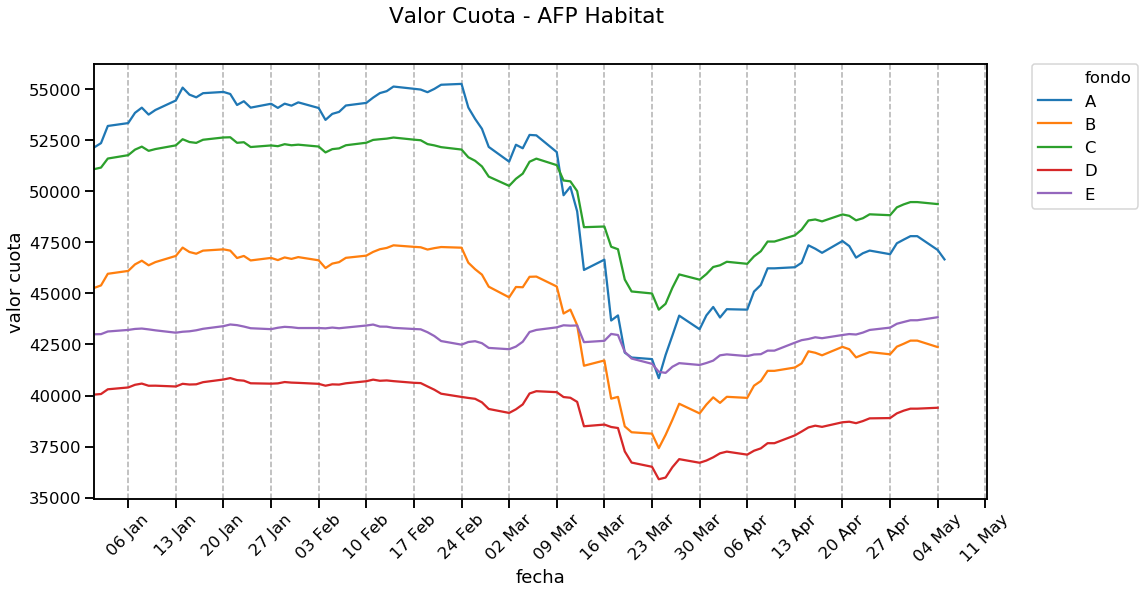

In [10]:
plotValue(afpDF, companyName='habitat', dataX='fecha', dataY='valor cuota')

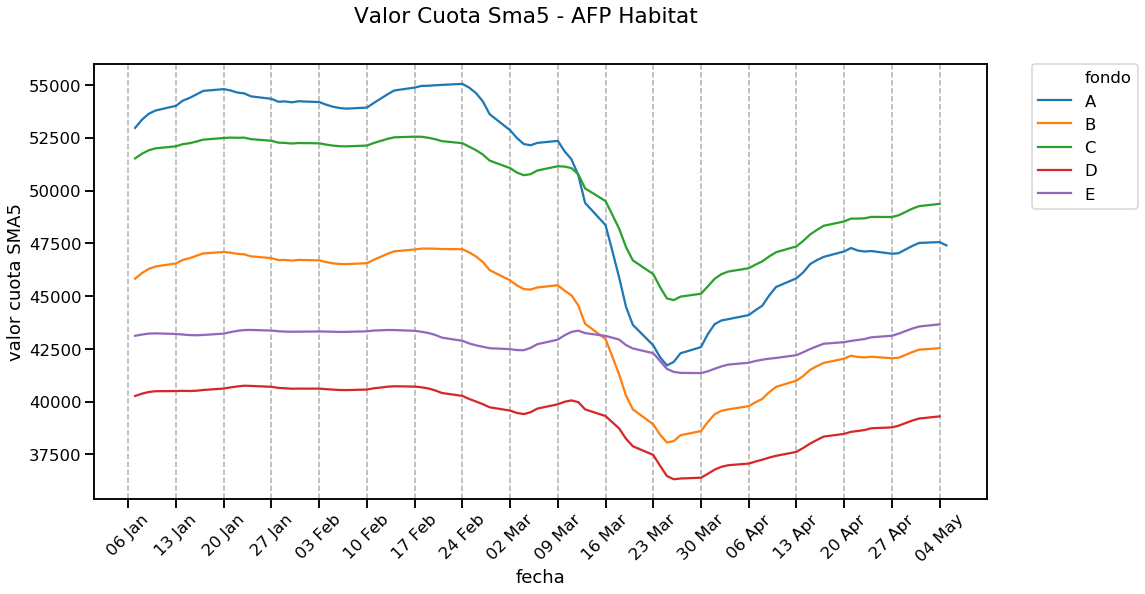

In [11]:
plotValue(afpDF, companyName='habitat', dataX='fecha', dataY='valor cuota SMA5')

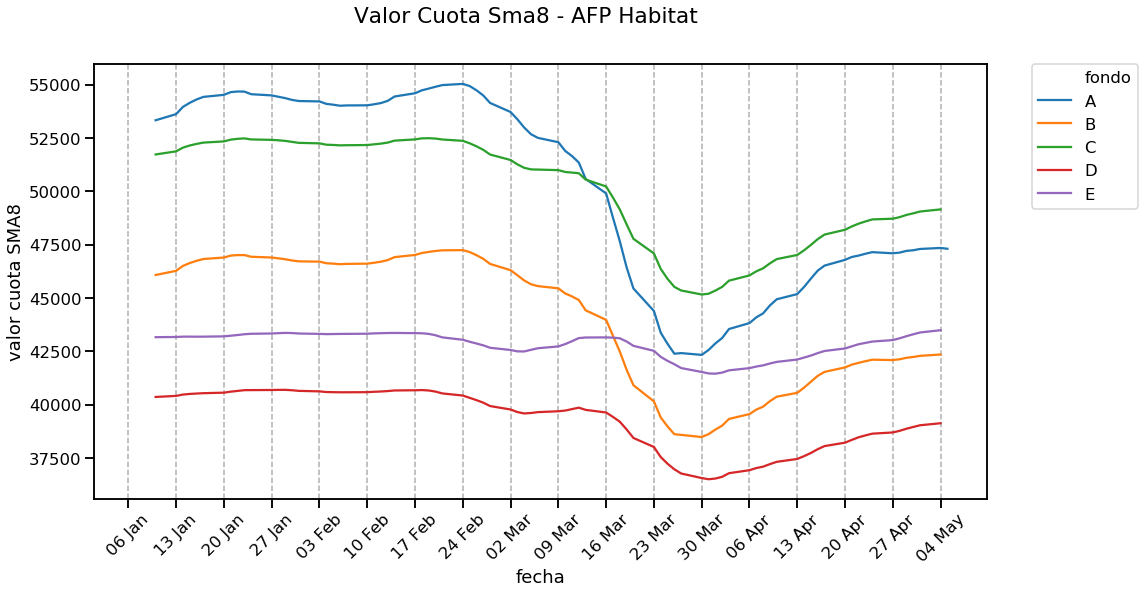

In [12]:
plotValue(afpDF, companyName='habitat', dataX='fecha', dataY='valor cuota SMA8')

## Análisis de rentabilidad

Rentabilidad YTD

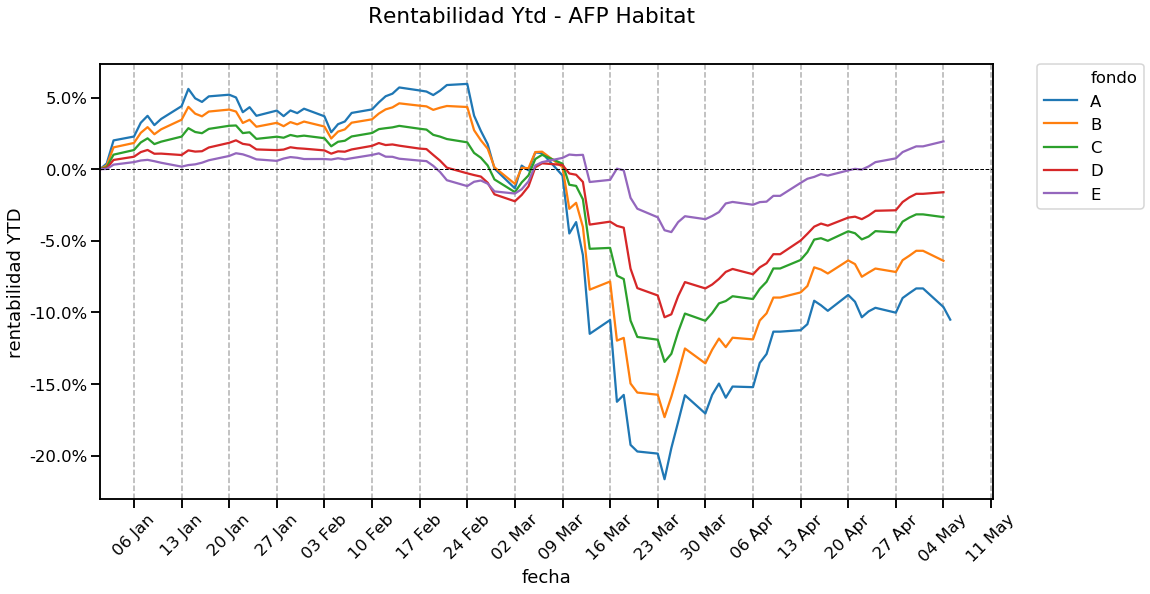

In [13]:
plotReturn(afpDF, companyName='habitat', dataX='fecha', dataY='rentabilidad YTD')

Rentabilidad Simple moving average 5 days

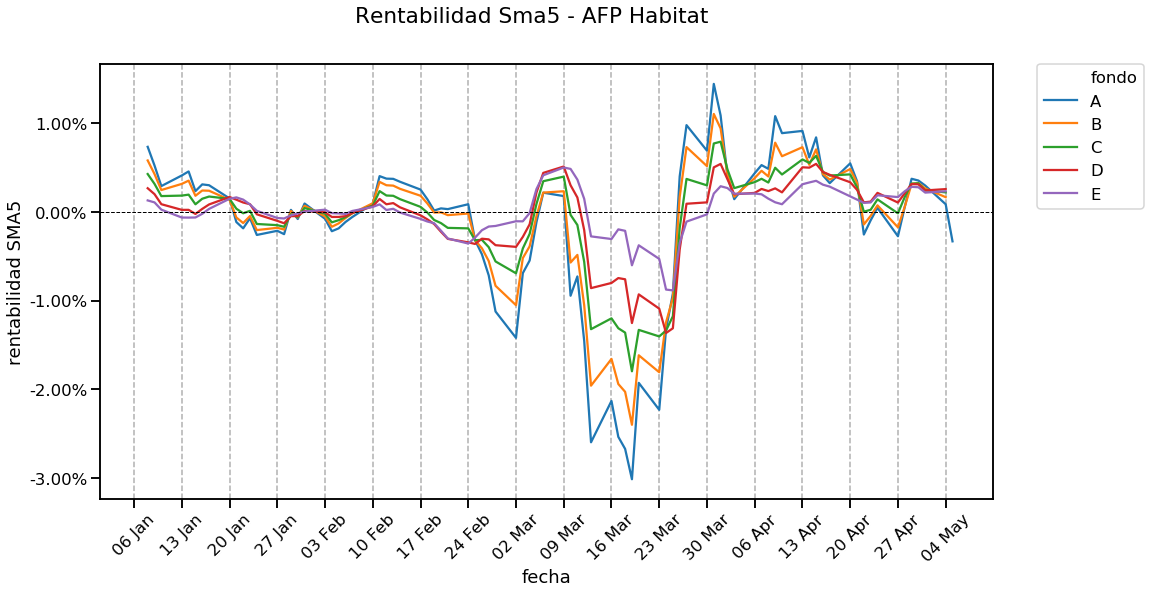

In [14]:
plotReturn(afpDF, companyName='habitat', dataX='fecha', dataY='rentabilidad SMA5')

Rentabilidad Simple moving average 8 days

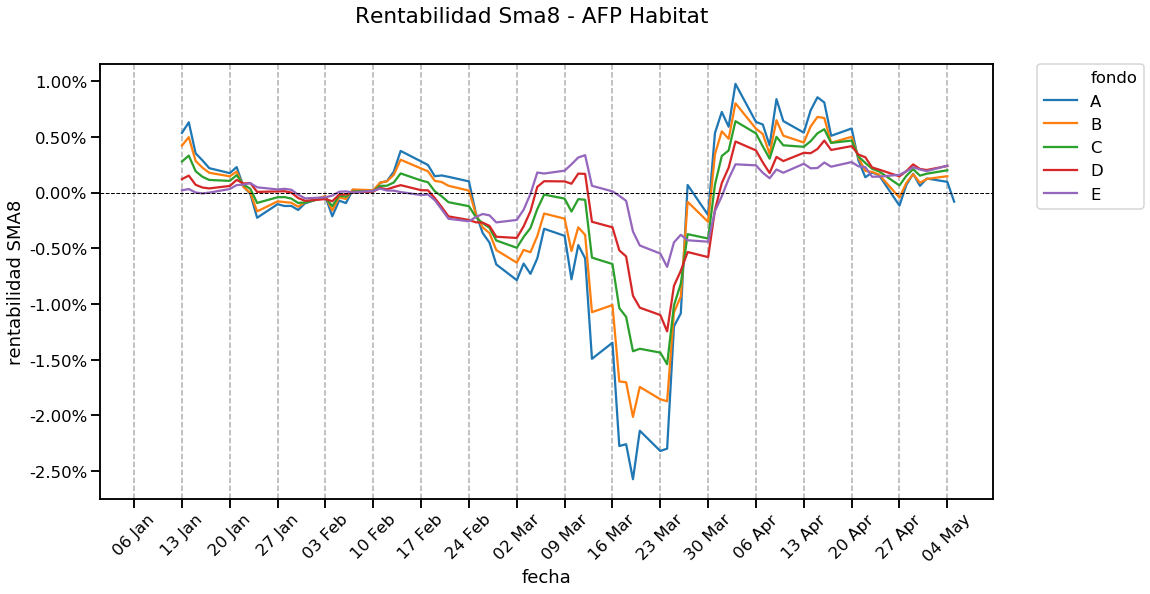

In [15]:
plotReturn(afpDF, companyName='habitat', dataX='fecha', dataY='rentabilidad SMA8')

# AFP Capital

## Análisis de rentabilidad

Rentabilidad YTD

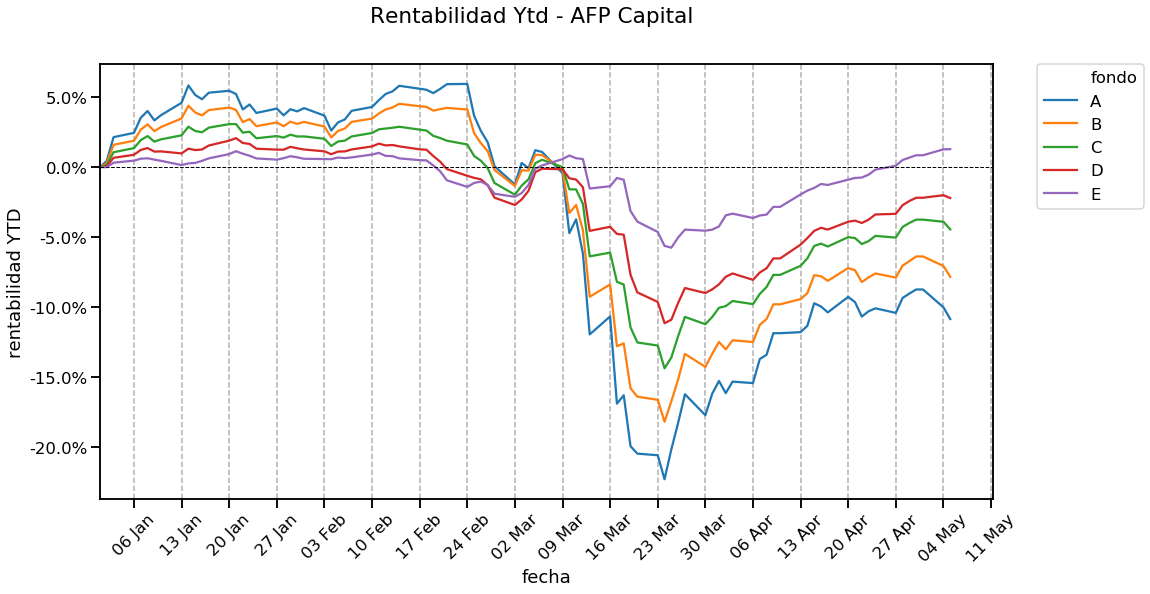

In [16]:
plotReturn(afpDF, companyName='capital', dataX='fecha', dataY='rentabilidad YTD')

Rentabilidad Simple moving average 5 days

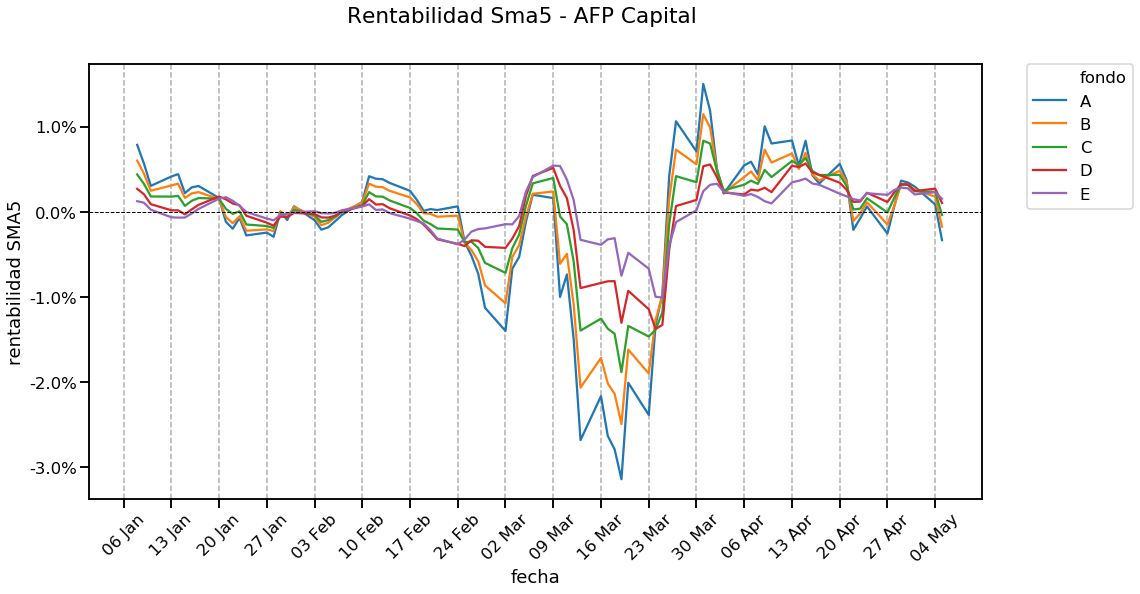

In [17]:
plotReturn(afpDF, companyName='capital', dataX='fecha', dataY='rentabilidad SMA5')

Rentabilidad Simple moving average 8 days

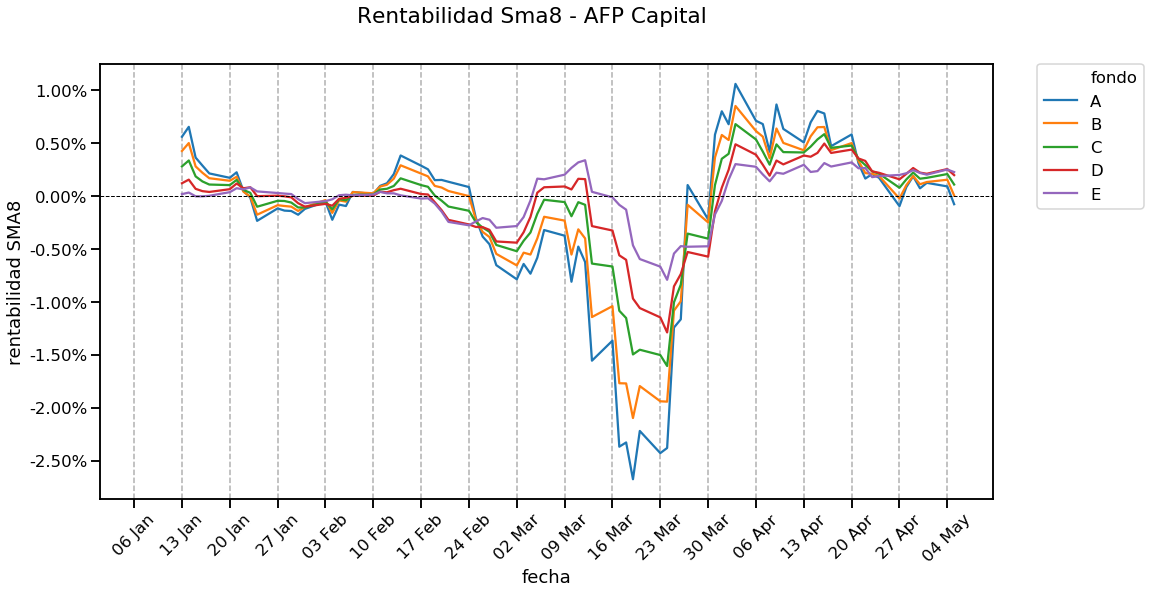

In [18]:
plotReturn(afpDF, companyName='capital', dataX='fecha', dataY='rentabilidad SMA8')